In [1]:
import os
import copy
from collections import OrderedDict
from tabulate import tabulate
import numpy as np
import math
import matplotlib.pyplot as plt
import flopy
import flopy.plot.styles as styles
from dis2disu import Dis2Disu

In [2]:
ws = './disu_model'

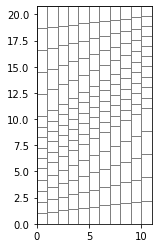

In [3]:
# Lx is the full width of the model. The grid spacing in the x direction is
# delr = Lx / ncol, and so the horizontal distance between the left and right
# boundary conditions is Lx - delr. The cells in the channel are square, i.e.,
# delz_chan = delr. The cross-sectional model has unit thickness "into the page,"
# i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay_chan * delz_chan.
# Theta is the angle (deg) at which the channel slopes, and so the width of the
# true" channel measured perpendicularly to the slope, i.e., the width available 
# for flow along the slope of the channel, is nlay_chan * delz_chan * cos(theta).
# The increase in elevation (vertical offset) as one moves a column to the right
# within the channel is delr * tan(theta).

# adjustable grid parameters
#nlay_chan, ncol = 6, 27
nlay_chan, ncol = 5, 11         # number of layers in channel, and number of columns in model
Lx = 11.0                       # full horizontal width of model
#Lx = 1000.0                       # full horizontal width of model
theta = 30.                     # angle of inclination of channel
#theta = 10.
#theta = math.atan(0.5) * 180. / math.pi
domain = True                    # option to include "domain" (True) or not (False)
k_dom = 1.e-6                   # domain conductivity
#k_dom = 0.001                     # domain_conductivity

# grid parameters intended to remain fixed
nrow = 1                        # model is one row deep "into the page"
delc = 1.                       # model has unit width "into the page"

# computed grid parameters
if domain:
    nlay_dom_upper = nlay_chan                      # number of layers in upper domain
else:
    nlay_dom_upper = 0
nlay_dom_lower = nlay_dom_upper                     # number of layers in lower domain
nlay = nlay_chan + nlay_dom_upper + nlay_dom_lower  # total number of layers
delr = float(Lx / ncol)                             # horizontal cell size
delz_chan = delr                                    # vertical cell size in channel
zoffset = delr * math.tan(theta * math.pi / 180.)   # vertical offset between cells in channel
zthick = nlay_chan * delz_chan                      # vertical thickness of channel
zspan = (ncol - 1) * zoffset + zthick               # total vertical span of channel
zthick_dom_ll = zthick                              # vertical thickness of lower domain at left boundary
zthick_dom_ur = zthick                              # vertical thickness of upper domain at right boundary

# set tops, bottoms, and conductivities; midpoints of cell tops/bottoms fall along
# the "true" top/bottom channel boundaries
botm = np.empty((nlay, nrow, ncol))
cond = np.ones((nlay, nrow, ncol))                  # unit conductivity in channel, set as default here
top_chan = zthick + 0.5 * zoffset \
    + np.linspace(0., (ncol - 1) * zoffset, ncol)
top_chan = top_chan.reshape((nrow, ncol))           # top of channel (without domain)
if domain:
    # upper domain
    Lz = zthick_dom_ll + zspan + zthick_dom_ur      # total height of model
    top_chan += zthick_dom_ll                       # add left-boundary thickness of lower domain to top of channel
    top = np.ones((nrow, ncol)) * Lz                # top of model
    dz = (top - top_chan) / nlay_dom_upper          # vertical cell size varies by column in domain
    botm[0] = top - dz                              # bottom of first layer is calculated using top
    cond[0] = k_dom
    for klay in range(1, nlay_dom_upper):
        botm[klay] = botm[klay - 1] - dz
        cond[klay] = k_dom
    # prepare to continue with channel discretization
    klaycontinue = nlay_dom_upper
else:
    # initialize channel discretization
    Lz = zspan                                     # total height of model
    top = top_chan                                 # top of model is top of channel
    botm[0] = top - delz_chan                      # bottom of first layer is calculated using top
    # prepare to continue channel discretization
    klaycontinue = 1
# channel
for klay in range(klaycontinue, nlay_dom_upper + nlay_chan):
    botm[klay] = botm[klay - 1] - delz_chan
if domain:
    # lower domain
    dz = (top_chan - zthick) / nlay_dom_lower     # vertical cell size varies by column in domain
    for klay in range(nlay_dom_upper + nlay_chan, nlay):
        botm[klay] = botm[klay - 1] - dz
        cond[klay] = k_dom

# plot dis grid
delr = delr * np.ones(ncol, dtype=float)
delc = delc * np.ones(nrow, dtype=float)
mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                          top=top, botm=botm)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
xs = flopy.plot.PlotCrossSection(modelgrid=mgs, ax=ax, line={"row":0})
xs.plot_grid()

In [4]:
# scenario parameters
# scenario names -- keys of parameters dictionary are scenario names
#                   built automatically from scenario options
# crossflow -- analytical flow is across the channel, i.e., crossflow (True)
#              or along the channel, i.e., axial flow (False)
# staggered -- vertically staggered grid, i.e., cross-connections (True)
#              or not, i.e., vertically offset (False)
# xt3d -- xt3d on (True) or off, i.e., standard formulation (False)

# scenario options
options = [
    {
        "optionname": "crossflow",
        "optionstrings": {
            False: "-af",
            True: "-cf",
        },   
    },
    {
        "optionname": "staggered",
        "optionstrings": {
            False: "-vo",
            True: "-vs",
        },
    },
    {
        "optionname": "xt3d",
        "optionstrings": {
            False: "-s",
            True: "-x",
        },
    },
]

# function that builds parameters (ordered) dictionary from scenario options
def build_parameters(options, *args, ioption=0):
    if ioption == 0:
        # initial call is without args, so set things up
        noptions = len(options)
        name = [""] * (noptions + 1)
        name[0] = "disu"
        if domain:
            name[0] = name[0] + "-d"
        parameters = OrderedDict()
        pdict = OrderedDict()
        args = (name, pdict, parameters)
    else:
        # after initial call, args is passed, so extract things from it
        args = args[0]
        name, pdict, parameters = args
    # loop over option values
    for optionval in [False, True]:
        # update parameter sub-dictionary and scenario name array
        pdict[options[ioption]["optionname"]] = optionval
        name[ioption + 1] = name[ioption] + options[ioption]["optionstrings"][optionval]
        if ioption == len(options) - 1:
            # last option, so copy parameter sub-dictionary to parameters with scenario name as key
            parameters[name[ioption + 1]] = copy.deepcopy(pdict)
        else:
            # call this routine recursively for the next option
            ioptionnext = ioption + 1
            parameters = build_parameters(options, args, ioption=ioptionnext)
    return parameters

# build parameters dictionary
parameters = build_parameters(options)

In [5]:
def calculate_head_analyt(crossflow):
    global head_analyt

    # Analytical head a la Bardot et al (2022),
    # assuming a head gradient of magnitude -1.
    # axial flow: head = - cos(theta) * x - sin(theta) * z
    # crossflow (assuming homogeneous K): head = sin(theta) * x - cos(theta) * z
    # For K = 1., these expressions give unit flux.
    
    # In the case of crossflow across a channel and domain of different
    # conductivities (heterogeneous), continuity of flow requires that the
    # head gradients in the channel and domain differ in inverse proportion
    # to the conductivities, so things are a little bit more complicated.

    thetarad = theta * math.pi / 180.
    sintheta = math.sin(thetarad)
    costheta = math.cos(thetarad)
    if crossflow:
        hgradx = sintheta
        hgradz = -costheta
        if domain:
            hgradx_dom = hgradx / k_dom
            hgradz_dom = hgradz / k_dom
    else:
        hgradx = -costheta
        hgradz = -sintheta
        if domain:
            hgradx_dom = hgradx
            hgradz_dom = hgradz

    head_analyt = []
    if domain:
        # upper domain
        xref2 = 0.
        zref2 = 0.
        href2 = 0.
        xref1 = 0.
        zref1 = zthick_dom_ll
        href1 = href2 + hgradx_dom * (xref1 - xref2) + hgradz_dom * (zref1 - zref2)
        xref0 = 0.
        zref0 = zref1 + zthick
        href0 =  href1 + hgradx * (xref0 - xref1) + hgradz * (zref0 - zref1)
        for klay in range(0, nlay_dom_upper):
            for jcol in range(ncol):
                xc = float(jcol + 0.5) * delr[0]
                xcrel = xc - xref0
                if klay == 0:
                    ztop = top[0][jcol]
                else:
                    ztop = botm[klay - 1][0][jcol]
                zc = 0.5 * (ztop + botm[klay][0][jcol])
                zcrel = zc - zref0
                hc = href0 + hgradx_dom * xcrel + hgradz_dom * zcrel
                head_analyt.append(hc)
    else:
        xref1 = 0.
        zref1 = 0.
        href1 = 0.
    # channel
    for klay in range(nlay_dom_upper, nlay_dom_upper + nlay_chan):
        for jcol in range(ncol):
            xc = float(jcol + 0.5) * delr[0]
            xcrel = xc - xref1
            if klay == 0:
                ztop = top[0][jcol]
            else:
                ztop = botm[klay - 1][0][jcol]
            zc = 0.5 * (ztop + botm[klay][0][jcol])
            zcrel = zc - zref1
            hc = href1 + hgradx * xcrel + hgradz * zcrel
            head_analyt.append(hc)
    if domain:
        # lower domain
        for klay in range(nlay_dom_upper + nlay_chan, nlay):
            for jcol in range(ncol):
                xc = float(jcol + 0.5) * delr[0]
                xcrel = xc - xref2
                if klay == 0:
                    ztop = top[0][jcol]
                else:
                    ztop = botm[klay - 1][0][jcol]
                zc = 0.5 * (ztop + botm[klay][0][jcol])
                zcrel = zc - zref2
                hc = href2 + hgradx_dom * xcrel + hgradz_dom * zcrel
                head_analyt.append(hc)

    return

In [6]:
def print_spdis_summary(qx, qy, qz, crossflow):

    jcolmid = int(ncol / 2)
    klaymid = int(nlay / 2)
    
    qmagmin = qangmin = qmagmid = float('inf')
    qmagmax = qangmax = qangmid = float('-inf')
    qmagavg = qangavg = 0.
    ncount = 0
    #icell = -1
    #for klay in range(nlay):
    icell = nlay_dom_upper * ncol - 1
    for klay in range(nlay_dom_upper, nlay_dom_upper + nlay_chan):
        for jcol in range(ncol):
            icell += 1
            qqx = qx[icell]
            qqz = qz[icell]
            qmag = math.sqrt(qqx * qqx + qqz * qqz)
            if (qqx == 0.):
                if (qqz == 0.):
                    qang = 0.
                elif (qqz > 0.):
                    qang = 90.
                else:
                    qang = -90.
            else:
                qang = math.atan2(qqz, qqx) * 180. / math.pi
            ncount += 1
            qmagmin = min([qmagmin, qmag])
            qmagmax = max([qmagmax, qmag])
            qmagavg += qmag
            qangmin = min([qangmin, qang])
            qangmax = max([qangmax, qang])
            qangavg += qang
            if (klay == klaymid) and (jcol == jcolmid):
                qmagmid = qmag
                qangmid = qang
    qmagavg = qmagavg / ncount
    qangavg = qangavg / ncount
    qmagana = 1.
    qangana = theta
    if crossflow:
        qangana += 90.

    print ("\nSPECIFIC DISCHARGE:")
    qdata = [
        ["analytical", qmagana, qangana],
        ["mid-channel", qmagmid, qangmid],
        ["avg channel", qmagavg, qangavg],
        ["min channel", qmagmin, qangmin],
        ["max channel", qmagmax, qangmax],
    ]
    qhead = ["", "magnitude", "angle",]
    print(tabulate(qdata, headers=qhead, tablefmt="simple", floatfmt=".14f"))
    
    return

In [7]:
def build_model(sim_name, xt3d, staggered, crossflow):
    global d2d
    
    # convert to disu grid
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered)
    
    sim_ws = os.path.join(ws, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws,
                                 exe_name='./bin/mf6')
#                                 exe_name='C:/Users/aprovost/Documents/ACTIVE/modflow6/bin/mf6') # kluge
    
    tdis = flopy.mf6.ModflowTdis(sim)
    #ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab')
    ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab',
#                               inner_dvclose=1e-12, inner_rclose=1e-12,
                              )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name,
                               save_flows=True, print_flows=True)
    disu = flopy.mf6.ModflowGwfdisu(gwf, **d2d.get_gridprops_disu6())
    ic = flopy.mf6.ModflowGwfic(gwf)
    npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                                  xt3doptions=xt3d, k=cond,
                                  angle1=0., angle2=0., angle3=0.)

    # Set boundary heads to analytical values
    calculate_head_analyt(crossflow)
    spd = []
    # specify heads along left and right sides of model
    for klay in range(nlay):
        icleft = klay*ncol
        icright = icleft + ncol - 1
        spd.append([(icleft,), head_analyt[icleft]])
        spd.append([(icright,), head_analyt[icright]])
    # if domain included or if crossflow, specify heads
    # along top and bottom of model
    if domain or crossflow:
        for jcol in range(1, ncol - 1):
##        spd = []                          # kluge
##        for jcol in range(0, ncol - 1):   # kluge
            ictoplay = jcol
            icbotlay = ictoplay + (nlay - 1) * ncol
            spd.append([(ictoplay,), head_analyt[ictoplay]])
            spd.append([(icbotlay,), head_analyt[icbotlay]])
##            spd.append([(ictoplay,), 0.e0])  # kluge
##            spd.append([(icbotlay,), 1.e8])  # kluge
#    if domain and crossflow and staggered and xt3d:   # kluge test
#        spd = []
#        ic = -1
#        for klay in range(nlay):
#            for jcol in range(ncol):
#                ic += 1
#                spd.append([(ic,), head_analyt[ic]])
            
    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=spd)

    budget_file = sim_name + '.bud'
    head_file = sim_name + '.hds'
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord=budget_file,
                                head_filerecord=head_file,
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                                printrecord=[('BUDGET', 'ALL'), ('HEAD', 'ALL')],)

    return sim

In [8]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_model(key, **params)
    sim.write_simulation(silent=silent)
    success, buff = sim.run_simulation(silent=silent, report=True)
    if not success:
        print(buff)
    else:
        plot_results(idx, sim)

In [9]:
def plot_results(idx, sim):

    sim_name = list(parameters.keys())[idx]
    sim_ws = os.path.join(ws, sim_name)
    gwf = sim.get_model(sim_name)
    staggered = parameters[sim_name]["staggered"]
    crossflow = parameters[sim_name]["crossflow"]
    
    simdata = [["sim_name", sim_name]]
    for key, value in parameters[sim_name].items():
        simdata.append([key, value])
    print(tabulate(simdata, tablefmt="simple", floatfmt=".14f"))
    
    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    # if cross-connections, recalculate qx taking into account overlap areas
    if staggered:
        flowja = bud.get_data(text='FLOW-JA')[0][0][0]
        gp = d2d.get_gridprops_disu6()
        iac = gp["iac"]
        ja = gp["ja"]
        ihc = gp["ihc"]
        topbycell = gp["top"]
        botbycell = gp["bot"]
        hwva = gp["hwva"]
        iconn = -1
        icell = -1
        for il in iac:
            icell += 1
            qxnumer = 0.
            qxdenom = 0.
            for ilnbr in range(il):
                iconn += 1
                if ihc[iconn] == 2:
                    inbr = ja[iconn]
                    if (inbr == icell):
                        continue
                    dz = min(topbycell[icell], topbycell[inbr]) - max(botbycell[icell], botbycell[inbr])
                    qxincr = flowja[iconn] / (hwva[iconn] * dz)
                    # equal weight given to each face, but could weight by distance instead
                    if (inbr < icell):
                        qxnumer += qxincr
                    else:
                        qxnumer -= qxincr
                    qxdenom += 1.
            qx[icell] = qxnumer / qxdenom
    # print specific discharge summary
    print_spdis_summary(qx, qy, qz, crossflow)

    # plot head and specific discharge and save figure
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_grid()
    cb = xs.plot_array(head, cmap="jet")
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Head, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    #xs.plot_vector(qx, qy, qz, scale=10, normalize=False, color="black",
    xs.plot_vector(qx, qy, qz, normalize=False, color="black",
                   width=0.0075, headwidth=3, headlength=5, headaxislength=4)
    fig.tight_layout()
    figure_ext = ".png"
    fpth0 = os.path.join(
        "..", "figures", "{}-head{}".format(sim_name, figure_ext)
    )
    plt.close(fig)
    fig.savefig(fpth0)
#    print (head.flatten()[297-1], head.flatten()[324-1])

    # plot head error and save figure
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_grid()
    cb = xs.plot_array(head - np.array(head_analyt), cmap="jet")
    
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Error, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    fig.tight_layout()
    figure_ext = ".png"
    fpth1 = os.path.join(
        "..", "figures", "{}-error{}".format(sim_name, figure_ext)
    )
    plt.close(fig)
    fig.savefig(fpth1)

    # display the two saved figures inline in a combined figure
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].set_axis_off()
    ax[0].imshow(plt.imread(fpth0))
    ax[1].set_axis_off()
    ax[1].imshow(plt.imread(fpth1))
    plt.show()
    
    return

---------  --------------
sim_name   disu-d-af-vo-s
crossflow  False
staggered  False
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.15603853065843   2.75711768267041
avg channel  1.17446290881432   7.78443074858349
min channel  0.72909832416509   0.85841963585939
max channel  1.64362849105417  27.62258306680918


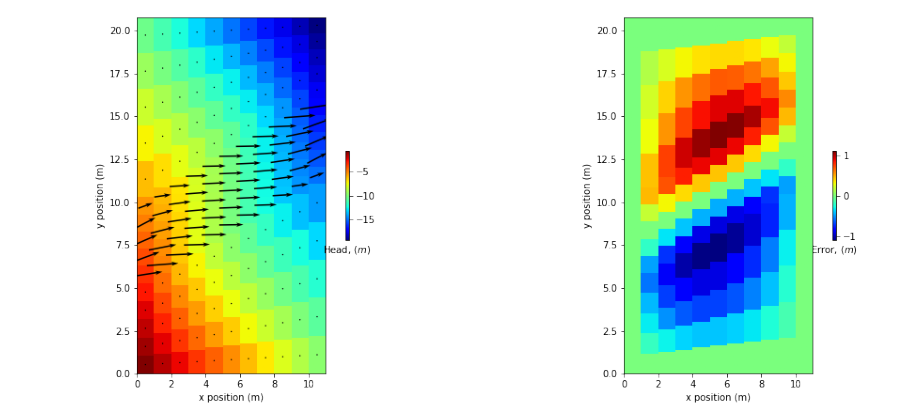

---------  --------------
sim_name   disu-d-af-vo-x
crossflow  False
staggered  False
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.06135682261739   2.85521296465828
avg channel  1.05435713252622   8.58769053857384
min channel  0.60631850638374   0.96933040452255
max channel  1.49788357013220  30.53404417351177


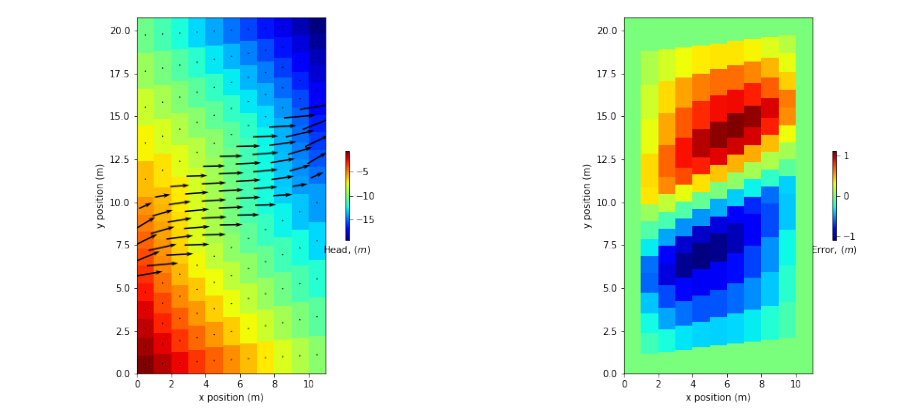

---------  --------------
sim_name   disu-d-af-vs-s
crossflow  False
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.02446300942480  24.24671125349860
avg channel  0.93718237106632  21.78000590858993
min channel  0.67646395111575  15.56168154873334
max channel  1.10697042945709  28.75349147847487


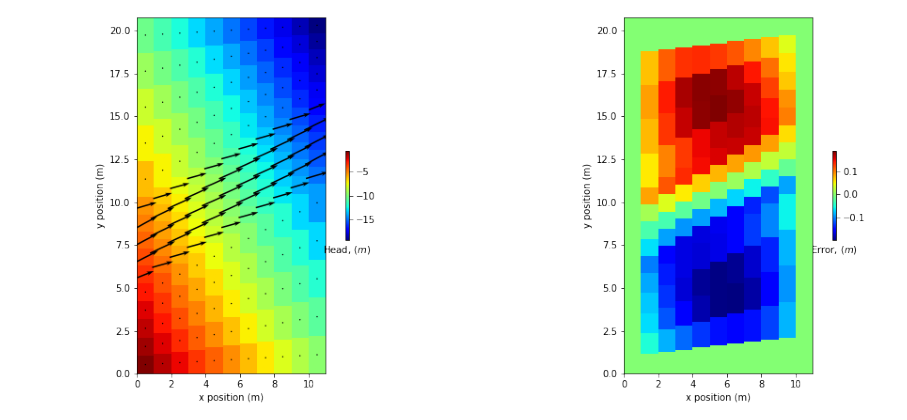

---------  --------------
sim_name   disu-d-af-vs-x
crossflow  False
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.00151347783178  30.00038252440116
avg channel  0.87608971783468  26.70664844173457
min channel  0.49582436820670  16.18382998585562
max channel  1.00313695321348  30.27904241444092


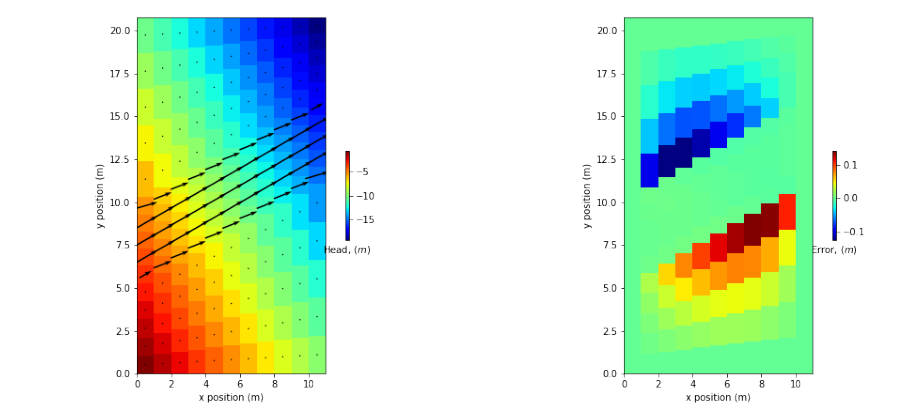

---------  --------------
sim_name   disu-d-cf-vo-s
crossflow  True
staggered  False
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  0.88880853844155   89.85026049654337
avg channel  0.88151045917960   90.02372522030092
min channel  0.86500119881716   89.27282323156220
max channel  0.89393845187684   91.44188359958450


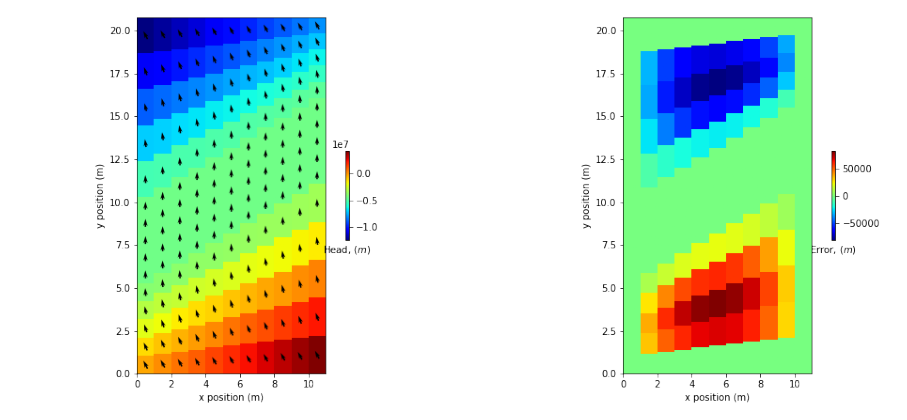

---------  --------------
sim_name   disu-d-cf-vo-x
crossflow  True
staggered  False
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                         magnitude                angle
-----------  ---------------------  -------------------
analytical        1.00000000000000   120.00000000000000
mid-channel    1658.89823906816150    29.52966194699379
avg channel   63080.82707715789729    74.09238418973230
min channel     394.71429938880772  -179.94088646456888
max channel  159459.84763520420529   179.99968248307763


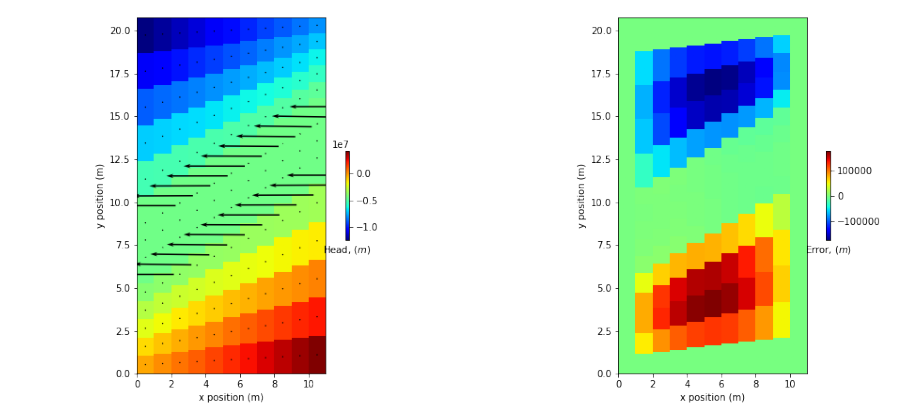

---------  --------------
sim_name   disu-d-cf-vs-s
crossflow  True
staggered  True
xt3d       False
---------  --------------

SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  1.11435523166131  121.78497022633935
avg channel  1.05005668534606  117.96726157964103
min channel  0.86896400917522   92.68125091704162
max channel  1.17097293792777  129.13817542794791


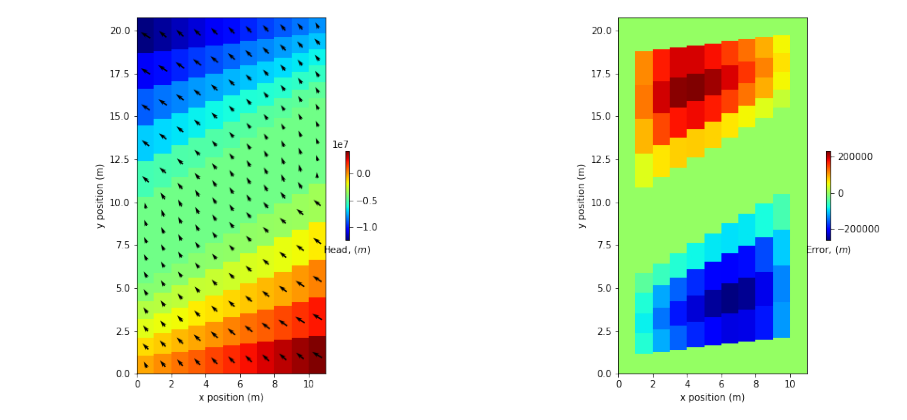

---------  --------------
sim_name   disu-d-cf-vs-x
crossflow  True
staggered  True
xt3d       True
---------  --------------

SPECIFIC DISCHARGE:
                        magnitude                angle
-----------  --------------------  -------------------
analytical       1.00000000000000   120.00000000000000
mid-channel   1905.04665721503011    52.59335559145300
avg channel  31865.85813755924028    97.99256585435585
min channel    542.60769749388635  -120.24965874523666
max channel  78611.63805187420803   179.99936735239820


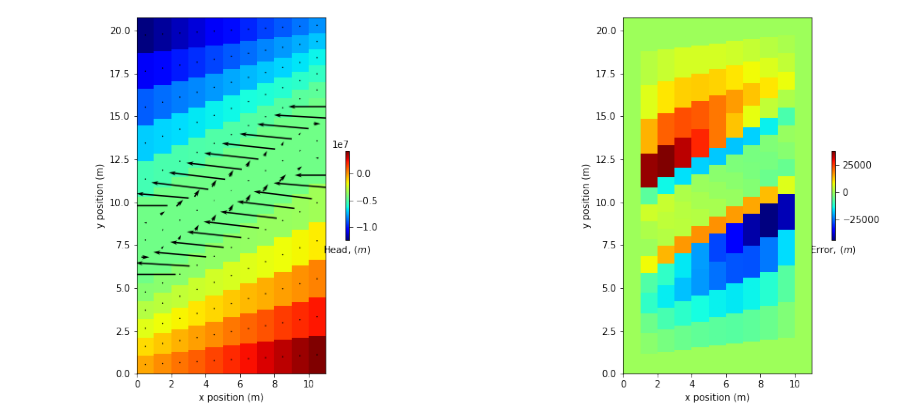

In [10]:
# run scenarios
for i in range(len(parameters)):
    simulation(i)